In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from models.vae_spike_glm import VAE_Spike_GLM, GLM_Encoder
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"
Z_file = "spk_loc.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file).flatten()

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
C_den = torch.from_numpy(C_den)
Z = torch.from_numpy(Z)

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 50
device = torch.device("cuda")
batch_size = 100000
iter_no = 30000
epoch_no = 15
#lr = 0.0025
sub_no = C_den.shape[0]

In [4]:
Z_train = Z[:T_train].to(device).float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = VAE_Spike_GLM(C_den=C_den,
                         C_syn_e=C_syn_e,
                         C_syn_i=C_syn_i,
                         T_no=T_no,
                         device = device)
encoder = GLM_Encoder(C_den=C_den,
                         C_syn_e=C_syn_e,
                         C_syn_i=C_syn_i,
                         T_no=T_no,
                         device = device)

encoder.to(device)
decoder.to(device)
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="none")

optimizer = torch.optim.Adam([
                {'params': encoder.parameters()},
                {'params': decoder.parameters()}], lr = 0.001)

260
318


In [6]:
loss_factor = 1
thresh = 3

temp_count = 0
temp_list = [0.5, 0.4, 0.3, 0.2, 0.1,
            0.09, 0.08, 0.07, 0.06,
            0.05, 0.04, 0.03, 0.02, 0.01]

Z_prior = torch.ones(batch_size, sub_no-1).to(device) * 0.001

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    
    if (i%500 == 0) & (temp_count < 14):
        temp = temp_list[temp_count]
        print(temp)
        temp_count += 1
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_Z = Z_train[batch_idx : batch_idx+batch_size]
    
    Z_hid, L_hid = encoder(batch_E_neural, batch_I_neural, batch_Z, temp)
    
    Z_enc = torch.zeros(batch_size, sub_no).to(device)
    Z_enc[:,0] = Z_enc[:,0] + batch_Z
    Z_enc[:,1:] = Z_enc[:,1:] + Z_hid
    
    Z_pred, out_filters = decoder.train_forward(batch_E_neural,
                                                batch_I_neural,
                                                Z_enc)   
    loss_weights = torch.ones(batch_size).to(device)
    Z_idx = torch.where(batch_Z == 1)[0]
    loss_weights[Z_idx] *= loss_factor
    
    bce_loss_1 = torch.mean(bce_criterion(Z_pred[:,0], batch_Z) * loss_weights)
    bce_loss_2 = torch.mean(bce_criterion(Z_pred[:,1:] , Z_hid.detach()))
    
    prior_loss = torch.mean(L_hid*torch.log(L_hid/Z_prior+1e-8) + (1-L_hid)*torch.log((1-L_hid)/(1-Z_prior)+1e-8))
    
    
    loss = bce_loss_1 + bce_loss_2 + prior_loss
    
    loss.backward()
    optimizer.step()
    
    if (i%1000==999) and (i > 20000):
        encoder.eval()
        decoder.eval()
        
        Z_pred, out_filters = decoder.test_forward(test_E_neural,
                                                test_I_neural)
        
        Z_idx = torch.where(Z_test == 1)[0]
        loss_weights = torch.ones(T_test).to(device)
        loss_weights[Z_idx] *= loss_factor
        
        Z_test_pred = Z_pred[:,0]
        
        test_bce = torch.mean(bce_criterion(Z_test_pred ,Z_test) * loss_weights)
        
        good_no = 0
        bad_no = 0
        
        for x in torch.where(Z_test_pred == 1)[0]:
            close_count = 0
            for y in torch.where(Z_test == 1)[0]:
                if torch.abs(x-y) <= thresh:
                    close_count += 1
            if close_count > 0:
                good_no += 1
            else:
                bad_no += 1
        
        print(i, good_no, bad_no, test_bce.item(), torch.sum(Z_pred[:,1:]).item())

<ipython-input-6-8b38ad04c5f7>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0.5
0.4
0.3
0.2
0.1
0.09
0.08
0.07
0.06
0.05
0.04
0.03
0.02
0.01
20999 2 126 0.5019999742507935 334.0
21999 5 93 0.4339999854564667 338.0
22999 1 123 0.49399998784065247 370.0
23999 1 98 0.4439999759197235 382.0
24999 1 106 0.4599999785423279 343.0
25999 1 130 0.5040000081062317 348.0
26999 2 114 0.4739999771118164 355.0
27999 4 124 0.49399998784065247 391.0
28999 1 116 0.47999998927116394 357.0
29999 5 118 0.48399999737739563 355.0



In [7]:
good_array = np.asarray([2,5,1,1,1,1,2,4,1,5])
bad_array = np.asarray([126,93,123,98,106,130,114,124,116,118])

print(np.mean(good_array), np.std(good_array))
print(np.mean(bad_array), np.std(bad_array))

2.3 1.6155494421403511
114.8 11.643023662262308


(0.8, 1.2)

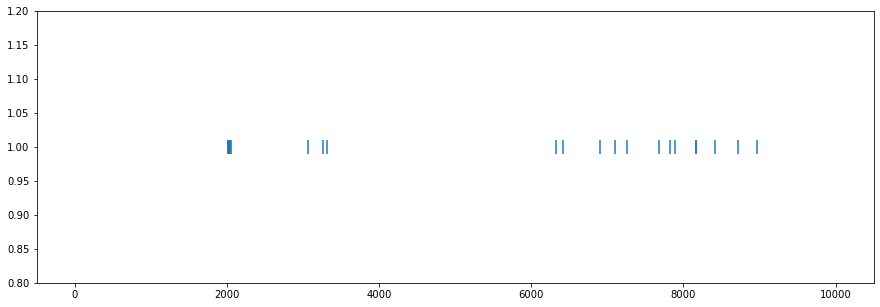

In [8]:
plt.figure(figsize = (15,5))
plt.scatter(torch.arange(10000), Z_test_pred[15000:25000].cpu().detach().numpy(), s=200, marker="|")
plt.ylim(0.8,1.2)

(0.8, 1.2)

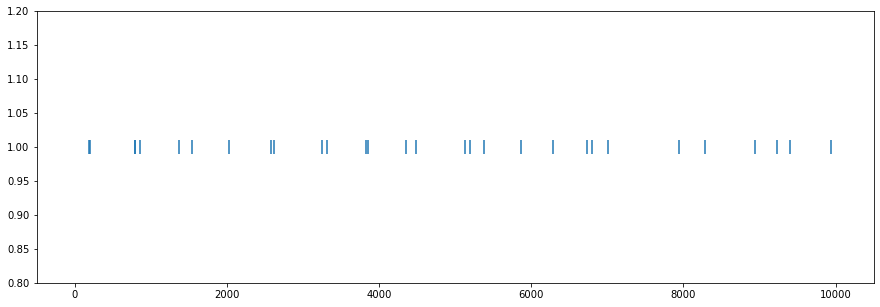

In [9]:
plt.figure(figsize = (15,5))
plt.scatter(torch.arange(10000), Z_test[15000:25000].cpu().detach().numpy(), s=200, marker="|")
plt.ylim(0.8,1.2)

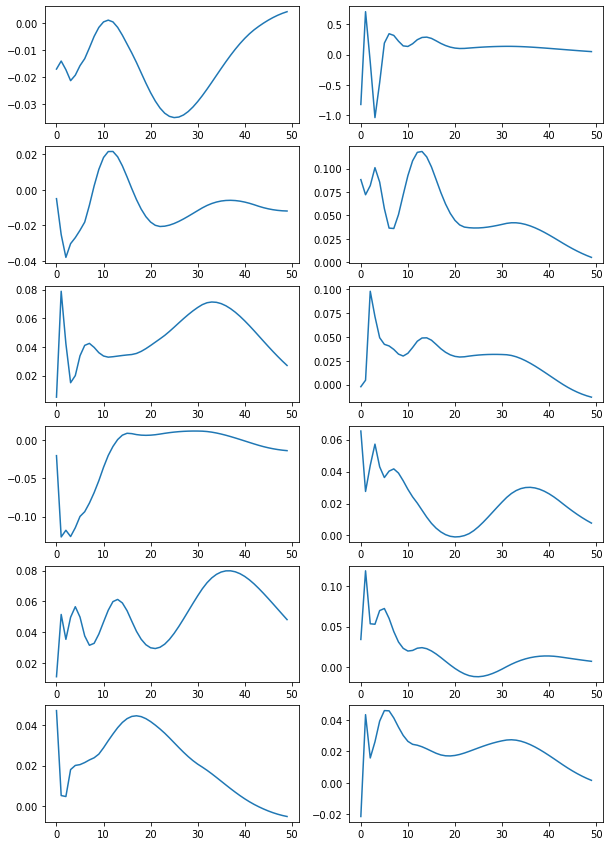

In [10]:
sub_no = 6
fig, axs = plt.subplots(nrows=sub_no,ncols=2, figsize=(10,15))
for i in range(sub_no):
    axs[i,0].plot(out_filters[i].cpu().detach().numpy())
    axs[i,1].plot(out_filters[i+sub_no].cpu().detach().numpy())
    


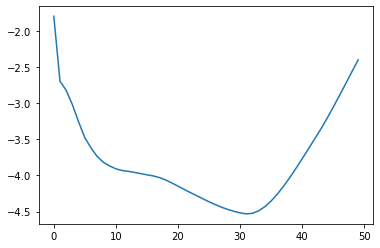

In [11]:
plt.plot(out_filters[-1].cpu().detach().numpy())

In [12]:
print(out_filters.shape)

torch.Size([24, 50])
